# Cartpole: Q-Table

## Introduction

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import gym
from sklearn.preprocessing import KBinsDiscretizer
from IPython.display import clear_output

In [16]:
name = 'CartPole-v1'
env = gym.make(name)

The game: A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

This game has a discrete action space but a continous state space. To form the Q-Table we must turn the continous state space into a discrete state space using a discretizer which uniformly divides the continous state space into a 2D grid of bins.

In [17]:
print('Action Space:', env.action_space) # Discrete action space
print('State Space:', env.observation_space) # Continous state space

Action Space: Discrete(2)
State Space: Box(4,)


## Generating the Q-Table

### Setting the parameters

In [18]:
n_episodes = 2000

discount_rate = 0.99

min_exp_rate = 0.01
exp_decay_rate = 0.001

min_learn_rate = 0.01
learn_decay_rate = 0.001

### Creating the discretizer to uniformly divide the continous state into bins

In [19]:
n_bins = (6,12)

# Pole angle between the low and high from the environment (-24,24) degrees
# Pole angular velocity between (-50,50) degrees
lower_bounds = [env.observation_space.low[2], -np.radians(50)]
upper_bounds = [env.observation_space.high[2], np.radians(50)]

# Converts the continous state space to a discrete state space
def discretizer(_, __, angle, pole_velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

### Initializing the Q-Table

In [20]:
q_table = np.zeros(n_bins + (env.action_space.n,))
q_table.shape

(6, 12, 2)

The Q-Table has 6 bins for the angle, 12 bins for the angular velocity and 2 bins for the actions

### Creating helper functions

In [21]:
# Best action given the state
def best_action(state:tuple):
    return np.argmax(q_table[state])

In [22]:
# Learning rate decay
def learning_rate(e:int) -> float  :
    return min_learn_rate + (1 - min_learn_rate) * np.exp(-learn_decay_rate*e)

In [23]:
# Exploration rate decay
def exploration_rate(e:int) -> float :
    return min_exp_rate + (1 - min_exp_rate) * np.exp(-exp_decay_rate*e)

### Building the Q-Table

In [24]:
scores = []

for e in range(n_episodes):
    
    # Discretize state into buckets
    current_state = discretizer(*env.reset())
    
    done = False
    score = 0
    while done!=True:
        
        # Choose between exploration and exploitation
        er = exploration_rate(e)
        if np.random.random() <= er: 
            action = env.action_space.sample() # Explore
        else:
            action = best_action(current_state) # Exploit
        
        # Increment enviroment
        observation, reward, done, _ = env.step(action)
        new_state = discretizer(*observation)
        
        # Update Q-Table according to the Bellman equation
        lr = learning_rate(e)
        old_value = q_table[current_state][action]
        learned_value = reward + discount_rate*np.max(q_table[new_state])
        q_table[current_state][action] = (1-lr)*old_value + lr*learned_value
        
        # Update variables
        current_state = new_state
        score+=1
        # env.render()
    
    scores.append(score)
    
    if len(scores)>50:
        if sum(scores[-50:])/100 > 200:
            break
    
    if e%100==0:
        print('Episode:', e)
        print('Average Score:', sum(scores[-100:])/100)
        print()

Episode: 0
Average Score: 0.27

Episode: 100
Average Score: 22.48

Episode: 200
Average Score: 22.86

Episode: 300
Average Score: 26.18

Episode: 400
Average Score: 32.36

Episode: 500
Average Score: 35.18

Episode: 600
Average Score: 34.43

Episode: 700
Average Score: 49.01

Episode: 800
Average Score: 54.37

Episode: 900
Average Score: 58.57

Episode: 1000
Average Score: 51.79

Episode: 1100
Average Score: 95.13

Episode: 1200
Average Score: 92.07

Episode: 1300
Average Score: 114.44

Episode: 1400
Average Score: 82.23

Episode: 1500
Average Score: 140.3

Episode: 1600
Average Score: 87.97

Episode: 1700
Average Score: 162.42

Episode: 1800
Average Score: 227.41



### Plotting the scores during learning

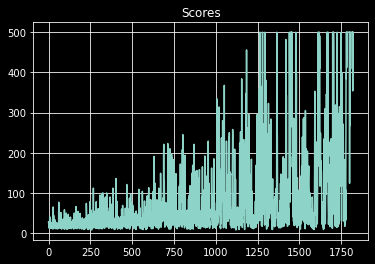

In [27]:
es = [e for e in range(len(scores))]
plt.plot(es, scores)
plt.title('Scores')
plt.grid()
plt.show()

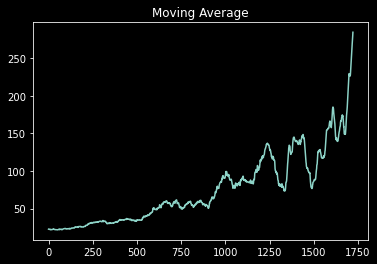

In [28]:
def moving_average(arr, n=10):
    ret = np.cumsum(arr)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:]/n

plt.title('Moving Average')
plt.plot(moving_average(scores, n=100));

The scores are increasing over time which means it's learning

## Playing the game

In [29]:
# Play the game 10 times with the calculated Q-Table
scores = []
for e in range(10):
    observation = env.reset()
    state = discretizer(*observation)
    done = False
    score = 0
    while done!=True:
        env.render()
        action = best_action(state)
        observation, reward, done, info = env.step(action)
        state = discretizer(*observation)
        score+=1
    scores.append(score)
    print('Episode:', e)
    print('Score:', score)
    clear_output(wait=True)
env.close()

Episode: 9
Score: 500


In [30]:
print('The average score is:', np.mean(scores))

The average score is: 500.0


Since 500 is the maximum score possible, the algorithm works well